This code is used to calculate the surface PGF via the SST and MSLP fields in ERA5 (anf zonally average after) and compare those with the formula that vertically integrates Tv gradients. The resulting figure is in the supporting information.  The gradients in both estimates are estimated via central finite differencing.

Author: Alex Gonzalez (alex.gonzalez@whoi.edu). Oct 2023.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import xarray as xr
#from netCDF4 import Dataset
import pandas as pd
#import netCDF4

from cartopy import config

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.ticker as mticker

from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
# wide latitudes
lats = -30
latn = 30

# longitudes
lonw = 235
lone = 270

# for zonal avgs
lonw_xavg = 235
lone_xavg = 270

In [4]:
figfolder = '/Users/alexgonzalez/Google Drive/My Drive/ITCZ_sblm_1D/ERA5/figures/'
dataset = 'ERA5'
dri = '/Volumes/alex.gonzalez/ERA5_smooth_clm/'

fn  = 'sst_1979-2021_monclm_hres.nc'
data = xr.open_dataset(dri+fn, engine='netcdf4')

fn  = 'mslp_1979-2021_monclm_hres.nc'
data_mslp = xr.open_dataset(dri+fn)

In [67]:
sst = data['sst'][:,::-1,:].sel(latitude=slice(lats,latn),longitude=slice(lonw,lone))

In [68]:
sst

<xarray.DataArray 'sst' (time: 12, latitude: 241, longitude: 141)>
[407772 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 2021-01-01 2021-02-01 ... 2021-12-01
  * longitude  (longitude) float32 235.0 235.2 235.5 235.8 ... 269.5 269.8 270.0
  * latitude   (latitude) float32 -30.0 -29.75 -29.5 -29.25 ... 29.5 29.75 30.0
Attributes:
    long_name:  Sea surface temperature
    units:      K

In [69]:
mslp = data_mslp['msl'][:,::-1,:].sel(latitude=slice(lats,latn),longitude=slice(lonw,lone))

In [70]:
mslp

<xarray.DataArray 'msl' (time: 12, latitude: 241, longitude: 141)>
[407772 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 2021-01-01 2021-02-01 ... 2021-12-01
  * longitude  (longitude) float32 235.0 235.2 235.5 235.8 ... 269.5 269.8 270.0
  * latitude   (latitude) float32 -30.0 -29.75 -29.5 -29.25 ... 29.5 29.75 30.0
Attributes:
    standard_name:  air_pressure_at_mean_sea_level
    long_name:      Mean sea level pressure
    units:          Pa

In [71]:
def center_fd_monlatlon(field_monlatlon,phi):
    [nmon,nlat,nlon] = field_monlatlon.shape
    
    field = np.swapaxes(field_monlatlon,1,2) # swap lat and lon axes

    dfdy = np.zeros((nmon,nlon,nlat))
    #print(field[:,:,1])
    dfdy[:,:,1:nlat-1] = (field[:,:,2:nlat] - field[:,:,0:nlat-2])/(phi[2:nlat] - phi[0:nlat-2])
    dfdy[:,:,0]        = (field[:,:,1] - field[:,:,0])/(phi[1] - phi[0])
    dfdy[:,:,nlat-1]   = (field[:,:,nlat-1] - field[:,:,nlat-2])/(phi[nlat-1] - phi[nlat-2])
    dfdy_final = dfdy
    
    dfdy_final = np.swapaxes(dfdy,1,2)  # swap lat and lon axes 
    return dfdy_final

In [85]:
lat = sst['latitude']
ae = 6.371e6
phi = lat*np.pi/180.
Rd = 287

In [86]:
dmslp_dy = center_fd_monlatlon(mslp.values,phi.values)/ae + sst*0

In [87]:
pgf_est = Rd*sst*dmslp_dy/mslp

In [88]:
# land-sea mask
fn_lsm = '/Volumes/alex.gonzalez/ERA5_smooth_clm/lsm_era5.nc'# load the land-sea mask here and do a where statement further down   
data_lsm = xr.open_dataset(fn_lsm)
lsm = data_lsm['lsm'][0,::-1,:].sel(latitude=slice(lats,latn),longitude=slice(lonw,lone))
lsm

<xarray.DataArray 'lsm' (latitude: 241, longitude: 141)>
array([[0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       ...,
       [0.      , 0.      , 0.      , ..., 0.634184, 0.592892, 0.445623],
       [0.      , 0.      , 0.      , ..., 0.83831 , 0.769277, 0.762959],
       [0.      , 0.      , 0.      , ..., 0.714556, 0.702074, 0.688584]],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float32 235.0 235.2 235.5 235.8 ... 269.5 269.8 270.0
  * latitude   (latitude) float32 -30.0 -29.75 -29.5 -29.25 ... 29.5 29.75 30.0
    time       datetime64[ns] 1979-01-01
Attributes:
    units:          (0 - 1)
    long_name:      Land-sea mask
    standard_name:  land_binary_mask

In [89]:
pgf_est_xavg = pgf_est.where(lsm==0).mean(dim='longitude')
pgf_est_xavg

<xarray.DataArray (time: 12, latitude: 241)>
array([[-1.90125283e-04, -1.96193481e-04, -2.05987362e-04, ...,
        -4.09748365e-05, -4.84318641e-05, -7.98835514e-05],
       [-1.96311457e-04, -2.02011746e-04, -2.10982970e-04, ...,
        -1.01483802e-04, -1.09866872e-04, -1.33968185e-04],
       [-1.54261091e-04, -1.59826944e-04, -1.68391876e-04, ...,
        -1.24050548e-04, -1.32366240e-04, -1.52572554e-04],
       ...,
       [-7.71898279e-05, -8.53428179e-05, -9.92930921e-05, ...,
        -5.18868166e-05, -5.99294218e-05, -9.48646452e-05],
       [-1.41469772e-04, -1.48890602e-04, -1.60979878e-04, ...,
        -2.67915396e-05, -3.51366740e-05, -7.01530170e-05],
       [-1.68265358e-04, -1.74452631e-04, -1.84470054e-04, ...,
        -3.38181015e-05, -4.23629597e-05, -7.37968972e-05]])
Coordinates:
  * time      (time) datetime64[ns] 2021-01-01 2021-02-01 ... 2021-12-01
  * latitude  (latitude) float32 -30.0 -29.75 -29.5 -29.25 ... 29.5 29.75 30.0

In [90]:
dri = '/Users/alexgonzalez/Google Drive/My Drive/ITCZ_sblm_1D/ERA5/progs/data_preproc/monthly/'
fn = 'pgf_Tv_mon.nc'

data_pgf_Tv = xr.open_dataset(dri+fn,engine='netcdf4')
data_pgf_Tv

<xarray.Dataset>
Dimensions:   (time: 12, latitude: 241)
Coordinates:
  * time      (time) datetime64[ns] 2021-01-01 2021-02-01 ... 2021-12-01
  * latitude  (latitude) float32 -30.0 -29.75 -29.5 -29.25 ... 29.5 29.75 30.0
Data variables:
    pgf       (time, latitude) float64 ...

In [94]:
pgf_act_xavg = data_pgf_Tv['pgf']
pgf_act_xavg

<xarray.DataArray 'pgf' (time: 12, latitude: 241)>
array([[-2.042936e-04, -2.086819e-04, -2.180456e-04, ..., -1.122566e-05,
        -2.239126e-05, -5.593459e-05],
       [-2.106483e-04, -2.137822e-04, -2.209054e-04, ..., -6.805308e-05,
        -7.977058e-05, -1.122200e-04],
       [-1.711593e-04, -1.745391e-04, -1.823602e-04, ..., -9.193679e-05,
        -1.041589e-04, -1.325158e-04],
       ...,
       [-1.052529e-04, -1.119953e-04, -1.257628e-04, ..., -3.122438e-05,
        -4.363339e-05, -6.918500e-05],
       [-1.656076e-04, -1.711893e-04, -1.826004e-04, ...,  2.738542e-06,
        -1.207431e-05, -4.477616e-05],
       [-1.857497e-04, -1.899883e-04, -1.991731e-04, ...,  2.966284e-07,
        -1.513149e-05, -4.989083e-05]])
Coordinates:
  * time      (time) datetime64[ns] 2021-01-01 2021-02-01 ... 2021-12-01
  * latitude  (latitude) float32 -30.0 -29.75 -29.5 -29.25 ... 29.5 29.75 30.0
Attributes:
    long_name:  Surface Pressure Gradient Force
    method:     Estimate From mass weighted vertical intergal of T_v distribu...
    notes:      longitudinally-averaged, ocean only
    units:      m s**-2

(-20.0, 20.0)

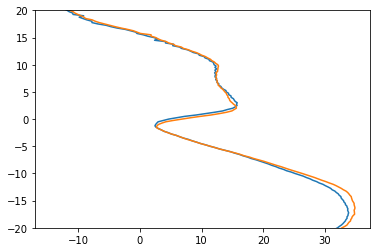

In [95]:
plt.plot(-pgf_est_xavg[8,:]*86400,lat)
plt.plot(-pgf_act_xavg[8,:]*86400,lat)
plt.ylim(-20,20)

In [34]:
# compute virtual temperature first by calculating saturated specific humidity
a1 = 611.21
a3 = 22.587
a4 = -0.7

Rd = 287.
Rv = 461.
T0 = 273.16

esat = a1*np.exp( a3*(sst-T0)/(sst-a4) )
qsat = (Rd/Rv)*esat/( mslp - (1-Rd/Rv)*esat )

sstv = sst1*( 1 + (Rv/Rd - 1)*qsat )

In [41]:
color_map_rb = plt.cm.get_cmap('RdBu').reversed()
lev_p = np.arange(-40,45,5)

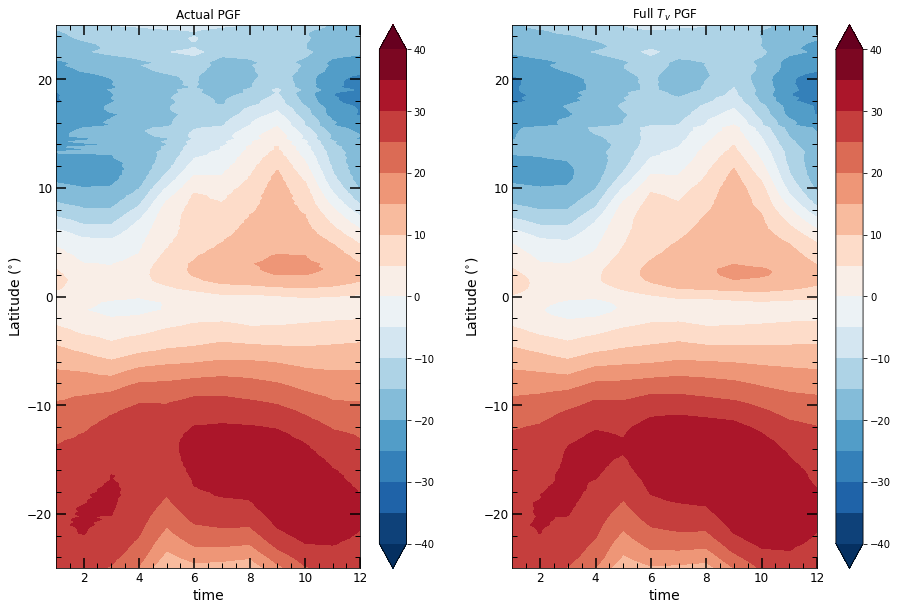

In [97]:
npan = 2
# all of the sizes are double the size they'll be in the paper 
fig = plt.figure(figsize=(15, 10))#, tight_layout='true')
for j in range(0,npan,1):
   ax1 = fig.add_subplot(1,2,j+1)
   plt.minorticks_on()
   ax1.tick_params(axis='both', which='major', length=10, width=1.5, direction='in', labelsize=12, right='True', top='True')
   ax1.tick_params(axis='both', which='minor', length= 5, width=1.0, direction='in', labelsize=12, right='True', top='True')
   ax1.tick_params(axis='x', labelsize=12)
   ax1.tick_params(axis='y', labelsize=12)
   #plt.gca().invert_yaxis() 
   plt.xlabel('time', fontsize=14)
   plt.ylabel('Latitude ($^{\circ}$)', fontsize=14)
   #plt.axhline(850, color='0.65', linewidth = 2.0)
   plt.ylim(-25,25)
   if j == 0:
       plt.title('Actual PGF')
       cf = plt.contourf(np.arange(1,13,1), pgf_est_xavg['latitude'], -pgf_est_xavg.transpose()*86400, cmap = color_map_rb, levels=lev_p, extend = 'both')
       cb = plt.colorbar(cf,orientation = 'vertical')
   if j == 1:
       plt.title(r'Full $T_v$ PGF')
       cf = plt.contourf(np.arange(1,13,1), pgf_est_xavg['latitude'], -pgf_act_xavg.transpose()*86400, cmap = color_map_rb, levels=lev_p, extend = 'both')
       cb = plt.colorbar(cf,orientation = 'vertical')

In [107]:
lats_final = -25
latn_final = 25
pga_act_flat = ( pgf_act_xavg.sel(latitude=slice(lats_final,latn_final)).values ).flat
pga_Tv_flat = ( pgf_est_xavg.sel(latitude=slice(lats_final,latn_final)).values ).flat

In [108]:
np.corrcoef(pga_act_flat,pga_Tv_flat)

array([[1.        , 0.99923018],
       [0.99923018, 1.        ]])

In [102]:
import scipy.stats
#corr_pga_SST = scipy.stats.pearsonr(pga_act_flat,pga_SST_flat)
corr_pga_Tv = scipy.stats.pearsonr(pga_act_flat,pga_Tv_flat)
corr_pga_Tv

(0.9992301798512288, 0.0)

In [106]:
[nt, nlat] = pgf_act_xavg.sel(latitude=slice(lats_final,latn_final)).shape

In [112]:
RMSE_Tv = np.sqrt( ( ( pgf_est_xavg.sel(latitude=slice(lats_final,latn_final))-pgf_act_xavg.sel(latitude=slice(lats_final,latn_final)) )**2/(nt*nlat) ).sum() )
RMSE_Tv.values

array(1.0108632e-05)

In [114]:
pgf_std = pgf_act_xavg.std(axis=1)
pgf_std 

<xarray.DataArray 'pgf' (time: 12)>
array([0.00023061, 0.00022685, 0.00022091, 0.00020178, 0.00017132,
       0.00016841, 0.00017866, 0.00017009, 0.0001743 , 0.00019352,
       0.00022043, 0.00023115])
Coordinates:
  * time     (time) datetime64[ns] 2021-01-01 2021-02-01 ... 2021-12-01

In [116]:
corr_vec = np.zeros((nt))
pval_vec = np.zeros((nt))

RMSE_SST_std_vec = np.zeros((nt))
RMSE_Tv_std_vec = np.zeros((nt))
for tt in range(0,nt,1):
    [corr, p_val] = scipy.stats.pearsonr(pgf_act_xavg[tt,:].sel(latitude=slice(lats_final,latn_final)),pgf_est_xavg[tt,:].sel(latitude=slice(lats_final,latn_final)))
    corr_vec[tt] = corr
    pval_vec[tt] = p_val
    
    RMSE_Tv_std_vec[tt] = np.sqrt( ( (pgf_est_xavg[tt,:].sel(latitude=slice(lats_final,latn_final))-pgf_act_xavg[tt,:].sel(latitude=slice(lats_final,latn_final)))**2/(nlat) ).sum() )/pgf_std[tt]

In [117]:
print(corr_vec.min())
print(corr_vec.max())

0.9990030739739896
0.9994297033660725


In [118]:
print(RMSE_Tv_std_vec.min())
print(RMSE_Tv_std_vec.max())

0.04145044523238303
0.0625114449882098


In [119]:
print(corr_SST_vec.min())
print(corr_SST_vec.max())

0.0
0.0


In [120]:
print(RMSE_SST_std_vec.min())
print(RMSE_SST_std_vec.max())

0.0
0.0


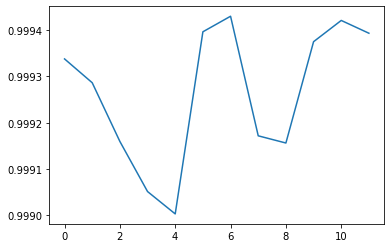

In [122]:
plt.plot(corr_vec)

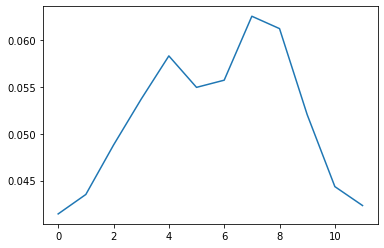

In [123]:
#plt.plot(RMSE_SST_std_vec)
plt.plot(RMSE_Tv_std_vec)

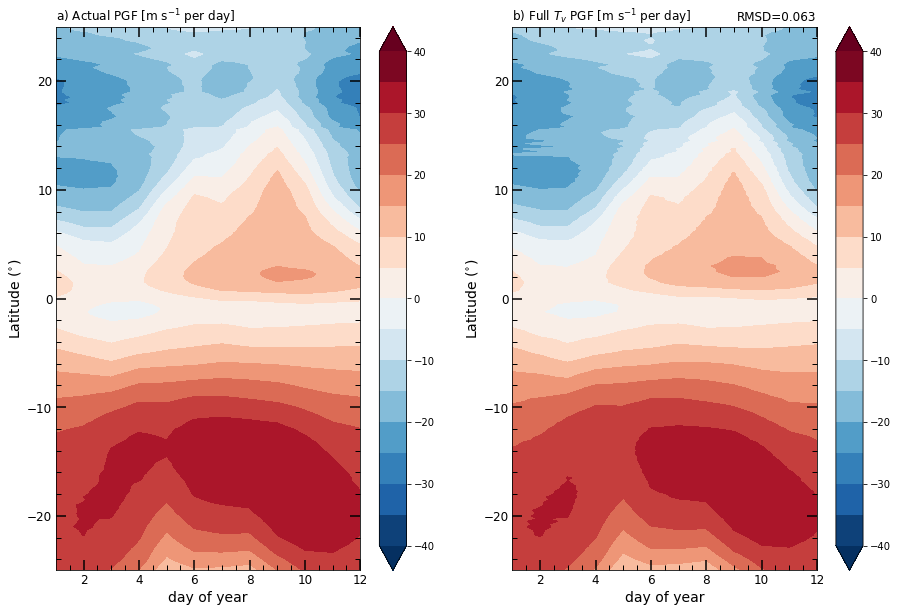

In [126]:
npan = 2
# all of the sizes are double the size they'll be in the paper 
fig = plt.figure(figsize=(15, 10))#, tight_layout='true')
for j in range(0,npan,1):
   ax1 = fig.add_subplot(1,2,j+1)
   plt.minorticks_on()
   ax1.tick_params(axis='both', which='major', length=10, width=1.5, direction='in', labelsize=12, right='True', top='True')
   ax1.tick_params(axis='both', which='minor', length= 5, width=1.0, direction='in', labelsize=12, right='True', top='True')
   ax1.tick_params(axis='x', labelsize=12)
   ax1.tick_params(axis='y', labelsize=12)
   #plt.gca().invert_yaxis() 
   plt.xlabel('day of year', fontsize=14)
   plt.ylabel('Latitude ($^{\circ}$)', fontsize=14)
   #plt.axhline(850, color='0.65', linewidth = 2.0)
   plt.ylim(-25,25)
   if j == 0:
       plt.title(r'a) Actual PGF [m s$^{-1}$ per day]',loc='left')
       cf = plt.contourf(np.arange(1,13,1), pgf_act_xavg['latitude'], -pgf_act.transpose()*86400, cmap = color_map_rb, levels=lev_p, extend = 'both')
       cb = plt.colorbar(cf,orientation = 'vertical')
   if j == 1:
       plt.title(r'b) Full $T_v$ PGF [m s$^{-1}$ per day]',loc='left')
       plt.title('RMSD='+str(np.round(RMSE_Tv_std_vec.max(),decimals=3)),loc='right')
       cf = plt.contourf(np.arange(1,13,1), pgf_act_xavg['latitude'], -pgf_est_xavg.transpose()*86400, cmap = color_map_rb, levels=lev_p, extend = 'both')
       cb = plt.colorbar(cf,orientation = 'vertical')
   if j == 2:
       plt.title(r'Full $T_v$ PGF (min r='+str(np.round(corr_vec.min(),decimals=5))+', RMSE='+str(np.round(RMSE_Tv.values,decimals=5))+')',loc='left')
       cf = plt.contourf(np.arange(1,367,1), pga_TvBL_xavg['latitude'], prc_Tv.transpose(), cmap = color_map_rb, levels=lev_p, extend = 'both')
       cb = plt.colorbar(cf,orientation = 'vertical')
        
figname = 'PGF_act_vs_Full_Tv.pdf'
plt.savefig(figfolder+figname, dpi=150)